In [103]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict,Literal
from pydantic import BaseModel,Field

In [104]:
load_dotenv()

True

In [105]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [106]:
class Sentiment(BaseModel):
    Sentiment:Literal["Positive","Negative"] = Field(...,description="Sentiment of the review")

In [107]:
llm=model.with_structured_output(Sentiment)

In [108]:
class Review(TypedDict):
    Review:str
    Sentiment:Literal["Positive","Negative"]
    diagnos:dict
    response:str

In [109]:
graph=StateGraph(Review)

In [110]:
def find_Sentiment(state:Review)->dict:
    prompt=f"For the following review find out the sentiment \n {state["Review"]}"
    return {"Sentiment":llm.invoke(prompt).Sentiment}

In [111]:
graph.add_node("find_Sentiment",find_Sentiment)


In [112]:
def check_review(state:Review)->Literal["Pos_Res","Run_diag"]:
    if state["Sentiment"]=="Positive":
        return "Pos_Res"
    else:
        return "Run_diag"

In [113]:
def Pos_Res(state:Review)->dict:
    Prompt=f"""
        Analyse this positive response:
        {state["Review"]}
        And thank the user and ask them to visit and leave a review on our website.
"""
    return{"response":llm.invoke(Prompt).content}

graph.add_node("Pos_Res",Pos_Res)

In [114]:
class DiagnosisSchema(BaseModel):
    issue_type:Literal["UI/UX","Performance","Bug","Support","other"]=Field(...,description="The type of issue the user is facing")
    tone:Literal["angry","frustrated","disappointed","clam"]=Field(...,description="what's the tone of the review")
    urgency:Literal["Low","medium","High"]=Field(...,description="How urgent the issue of the user is?")

In [115]:
llm_2=model.with_structured_output(DiagnosisSchema)

In [116]:
def Run_diag(state:Review)->dict:
    prompt=f"""Diagnose the negative review:
    {state["Review"]}
    Return issue type,tone and urgency"""
    
    return {"diagnos":llm_2.invoke(prompt).model_dump()}

graph.add_node("Run_diag",Run_diag)

In [117]:
def Neg_rev(state:Review)->dict:
    diag=state["diagnos"]
    prompt=f"""
    You are a support agent
    The user had a '{diag["issue_type"]}' issue which sounded '{diag["tone"]}', and marked urgency
    {diag["urgency"]}.
    Write a message filled with empathy,with the resolution.

"""
    return {"response":model.invoke(prompt).content}

graph.add_node("Neg_rev",Neg_rev)

In [118]:
graph.add_edge(START,"find_Sentiment")
graph.add_conditional_edges("find_Sentiment",check_review)
graph.add_edge("Run_diag","Neg_rev")
graph.add_edge("Neg_rev",END)
graph.add_edge("Pos_Res",END)

In [119]:
workflow=graph.compile()

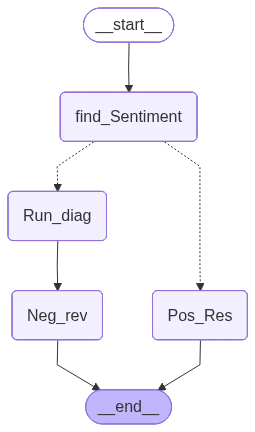

In [120]:
workflow

In [121]:
workflow.invoke({"Review":"1/10 - Avoid This Website at All Costs**\n\nI\'m still trying to figure out how a website as poorly designed and user-unfriendly as this one managed to make it onto the internet. I attempted to purchase a product from their online store, but it was an exercise in frustration from start to finish.\n\nFirst of all, the website loads at a snail\'s pace. I\'m talking 30 seconds or more just to get to the homepage. And don\'t even get me started on the 'responsive design' - it looks like they took a few lazy attempts at making it work on mobile, but ultimately just gave up.\n\nWhen I finally managed to navigate to the product page, I was greeted with a sea of clutter. Too many unnecessary images, too many awkwardly-placed ads, and a navigation bar that looks like it was cobbled together by a kindergartener.\n\nBut the real kicker is the checkout process. It\'s like they intentionally designed it to be as painful as possible. I had to enter my information multiple times, and even then, the site kept throwing errors and telling me that my payment wasn\'t processed. I ended up having to call their customer support (which, by the way, is only available by phone and not via email or chat) to get it sorted out.\n\nAnd don\'t even get me started on the customer support itself. The person I spoke to was completely unhelpful and seemed like they\'d rather be anywhere else. When I asked them to refund my money, they told me that it would take 2-3 weeks to process, but 'maybe' they could expedite it for an additional fee.\n\nNeedless to say, I will never be shopping on this site again. If you value your sanity and your wallet, stay far, far away from this disaster of a website.\n\n**UPDATE**\n\nI\'ve just received an email from the company 'responding' to my review, and it\'s just as unhelpful as you\'d expect. They\'re essentially saying that I must have done something wrong and that the issue was with my browser or internet connection. Um, no. It\'s not me, it\'s you. Fix your website.\n\n**UPDATE 2**\n\nI just tried to log back into the website to see if anything has changed, and I\'m getting a 'database error' message. Yeah, that\'s reassuring."})

{'Review': "1/10 - Avoid This Website at All Costs**\n\nI'm still trying to figure out how a website as poorly designed and user-unfriendly as this one managed to make it onto the internet. I attempted to purchase a product from their online store, but it was an exercise in frustration from start to finish.\n\nFirst of all, the website loads at a snail's pace. I'm talking 30 seconds or more just to get to the homepage. And don't even get me started on the 'responsive design' - it looks like they took a few lazy attempts at making it work on mobile, but ultimately just gave up.\n\nWhen I finally managed to navigate to the product page, I was greeted with a sea of clutter. Too many unnecessary images, too many awkwardly-placed ads, and a navigation bar that looks like it was cobbled together by a kindergartener.\n\nBut the real kicker is the checkout process. It's like they intentionally designed it to be as painful as possible. I had to enter my information multiple times, and even then